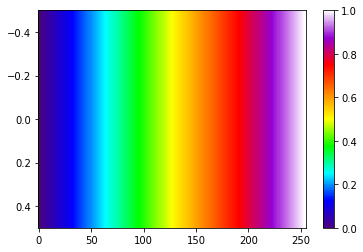

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pyvista as pv

# Définir les couleurs du bas au haut de la colormap de l'image
colors = [
    (75/255, 0, 130/255),   # indigo
    (0, 0, 255/255),        # bleu
    (0, 255/255, 255/255),  # cyan
    (0, 255/255, 0),        # vert
    (255/255, 255/255, 0),  # jaune
    (255/255, 127/255, 0),  # orange
    (255/255, 0 , 0),        # rouge
    (148/255, 0, 211/255),  # violet
    (1, 1, 1)               # blanc

]

cmap_name = 'custom_gradient'

# Créer la colormap
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)


# Afficher la colormap dans Matplotlib
plt.imshow(np.linspace(0, 1, 256)[None, :], aspect='auto', cmap=custom_cmap)
plt.colorbar()
plt.show()


In [2]:
import os
import feelpp
from feelpp.toolboxes.cfpdes import *
from tools.lap2D_pinns import Run_laplacian2D, Poisson_2D, PoissonDisk2D
from scimba.equations import domain
from tools.GeoToMsh import geo_to_msh
from tools.GmeshRead import mesh2d

import pyvista as pv 
import pandas as pd
import numpy as np

import plotly.express as px
from plotly.subplots import make_subplots
import itertools
import torch
from pathlib import Path

class Poisson:
  """
  Solves the problem
  -Laplacian u = f   in Omega
  u            = g   in boundary
  
  - with f,g are set by the user
  """
  def __init__(self, dim=2, order=1):

    self.dim   = dim
    self.model = dict()
    self.order = order  
##______________________________________________________________________________________________


  def genCube(self, filename, h=0.1, shape = 'Rectangle'):
    """
    Generate a cube geometry following the dimension  self.dim
    """

    
    geo="""SetFactory("OpenCASCADE");
    h={};
    dim={};
    """.format(h, self.dim)
    
    if self.dim==2 :
      if shape == 'Rectangle':  
        geo+="""
        Rectangle(1) = {0, 0, 0, 1, 1, 0};
        Characteristic Length{ PointsOf{ Surface{1}; } } = h;
        Physical Curve("Gamma_D") = {1,2,3,4};
        Physical Surface("Omega") = {1};
        """
      elif shape == 'Disk':
        geo += """
              Disk(1) = {0, 0, 0, 1.0};
              Physical Curve("Gamma_D") = {1};
              Physical Surface("Omega") = {1};
              """

    elif self.dim == 3:
      if shape == 'Box':
        geo += """
        Box(1) = {0, 0, 0, 1, 1, 1};
        Characteristic Length{ PointsOf{ Volume{1}; } } = h;
        Physical Surface("Gamma_D") = {1,2,3,4,5,6};
        Physical Volume("Omega") = {1};
        """
        
      elif shape == 'Sphere':
        geo += """
        Sphere(1) = {0, 0, 0, 1.0};
        Physical Surface("Gamma_D") = {1};
        Physical Volume("Omega") = {1};
        """
    with open(filename, 'w') as f:
      f.write(geo)
##______________________________________________________________________________________________

  def getMesh(self, filename,hsize=0.05,dim=2,verbose=False):
    """create mesh

    Args:
        filename (str): name of the file
        hsize (float): mesh size
        dim (int): dimension of the mesh
        verbose (bool): verbose mode
    """
    import os
    for ext in [".msh",".geo"]:
      f=os.path.splitext(filename)[0]+ext
      if os.path.exists(f):
        os.remove(f)
    if verbose:
      print(f"generate mesh {filename} with hsize={hsize} and dimension={dim}")
    self.genGeometry(filename, h=hsize, shape='Rectangle')
    mesh = feelpp.load(feelpp.mesh(dim=dim,realdim=dim), filename, hsize)
    return mesh

##______________________________________________________________________________________________

  def feel_solver(self, filename, h, json, dim=2,verbose=False):
    if verbose:
      print(f"Solving the laplacian problem for hsize = {h}...")
    feelpp_mesh = feelpp.load(feelpp.mesh(dim=self.dim, realdim=self.dim), filename, h)
    self.pb.setMesh(feelpp_mesh)    
    self.pb.setModelProperties(json)
    self.pb.init(buildModelAlgebraicFactory=True)
    self.pb.printAndSaveInfo()
    self.pb.solve()
    self.pb.exportResults()
    measures = self.pb.postProcessMeasures().values()
    return measures
  
##______________________________________________________________________________________________

  def scimba_solver(self, shape='Rectangle', h=0.05, dim = 2, verbose=False):
    if verbose:
      print(f"Solving a Poisson problem for hsize = {h}...")    
    
    diff = self.diff.replace('{', '(').replace('}', ')')
    
    if shape == 'disk':
      xdomain = domain.SpaceDomain(2, domain.DiskBasedDomain(2, center=[0.0, 0.0], radius=1.0))
      pde = PoissonDisk2D(xdomain, rhs=self.rhs, diff=diff, g=self.g, u_exact=self.u_exact)
      network, pde = Run_laplacian2D(pde)

    elif shape == 'Rectangle':
      xdomain = domain.SpaceDomain(2, domain.SquareDomain(2, [[0.0, 1.0], [0.0, 1.0]]))
      pde = Poisson_2D(xdomain, rhs=self.rhs, diff=diff, g=self.g, u_exact=self.u_exact)
      network, pde = Run_laplacian2D(pde)
  

    # Extract solution function u
    u = network.forward

    return u

##______________________________________________________________________________________________
  
  def __call__(self,
               h=0.05,                                      # mesh size 
               order=1,                                     # polynomial order 
               name='u',                                    # name of the variable u
               rhs='8*pi*pi*sin(2*pi*x)*sin(2*pi*y)',       # right hand side
               diff='{1,0,0,1}',                            # diffusion matrix
               g='0',                                       # boundary conditions
               shape='Rectangle',                           # domain shape (Rectangle, Disk)    
               geofile=None,                                # geometry file
               plot=1,                                      # plot the solution
               solver='feelpp',                             # solver 
               u_exact='sin(2 * pi * x) * sin(2 * pi * y)',
               grad_u_exact = '{2*pi*cos(2*pi*x)*sin(2*pi*y),2*pi*sin(2*pi*x)*cos(2*pi*y)}' 
               ):
    """
    Solves the problem where :
    - h is the mesh size
    - order the polynomial order
    - rhs is the expression of the right-hand side f(x,y)
    """
    self.measures = dict()
    self.rhs = rhs
    self.g = g
    self.u_exact = u_exact
    self.diff = diff
    self.pb    = cfpdes(dim=self.dim, keyword=f"cfpdes-{self.dim}d-p{self.order}")
    self.model = {
      "Name": "Poisson",
      "ShortName": "Poisson",
      "Models":
      {
        f"cfpdes-{self.dim}d-p{self.order}":
        {
          "equations":"poisson"
        },
        "poisson":{
          "setup":{
            "unknown":{
              "basis":f"Pch{order}",
              "name":f"{name}",
              "symbol":"u"
            },
            "coefficients":{
              "c": f"{diff}:x:y" if self.dim == 2 else f"{diff}:x:y:z",
              "f": f"{rhs}:x:y"  if self.dim == 2 else f"{rhs}:x:y:z"
            }
          }
        }
      },
      "Materials":
      {
        "Omega":
        {
          "markers":["Omega"]
        }
      },
      "BoundaryConditions":
      {
        "poisson":
        {
          "Dirichlet":
          {
            "g":
            {
              "markers":["Gamma_D"],
              "expr":f"{g}:x:y"
            }
          }
        }
      },
      "PostProcess":
      {
        f"cfpdes-{self.dim}d-p{self.order}":
        {
          "Exports":
          {
            "fields":["all"],
            "expr":{
              #"u_scimba": f"{name}:x:y" if self.dim == 2 else f"{name}:x:y:z",
              "rhs": f"{rhs}:x:y" if self.dim == 2 else f"{rhs}:x:y:z",
              "u_exact" : f"{u_exact}:x:y" if self.dim==2 else f"{u_exact}:x:y:z",
              "grad_u_exact" : f"{grad_u_exact}:x:y" if self.dim==2 else f"{grad_u_exact}:x:y:z",
            }
          },
            "Measures" :
            {
              "Norm" :
              {
                  "poisson" :
                  {
                     "type":["L2-error", "H1-error"],
                     "field":f"poisson.{name}",
                     "solution": f"{u_exact}:x:y" if self.dim==2 else f"{u_exact}:x:y:z",
                     "grad_solution": f"{grad_u_exact}:x:y" if self.dim==2 else f"{grad_u_exact}:x:y:z",
                     "markers":"Omega",
                     "quad":6
                 }
              },
                "Statistics":
                {
                    "mystatA":
                    {
                        "type":["min","max","mean","integrate"],
                        "field":f"poisson.{name}"
                    }
                }
            }
        }
      }
    }
    
    """
    fn = f'omega-{self.dim}.geo'
    self.genGeometry(fn, h=h, shape=geofile)
    """
    fn = None
    if geofile is None:
      fn = f'omega-{self.dim}.geo'
      self.genCube(fn, h, shape=shape)
    else:
      fn = geofile    
##________________________

  # Solving

    self.measures = self.feel_solver(filename=fn, h=h, json=self.model, dim=self.dim, verbose=True)
      
    if solver == 'scimba':
      import pyvista as pv
      import torch

      u_scimba = self.scimba_solver(shape=shape, h=h, dim=self.dim, verbose=True)
      
      # File path to the .case file
      file_path = 'cfpdes-2d-p1.exports/Export.case'

      # Read the .case file using PyVista
      data = pv.read(file_path)

      # Iterate over each block in the dataset to find coordinates
      coordinates = None
      for i, block in enumerate(data):
          if block is None:
              continue

          print(f"Block {i}:")
          print(block)
          
          # Extract the mesh points (coordinates)
          coordinates = block.points

      # Ensure coordinates are found
      if coordinates is None:
          raise ValueError("No coordinates found in the mesh blocks.")

      # Print the first few coordinates to understand their structure
      print("First few coordinates:")
      print(coordinates[:5])

      # Determine the number of features
      num_features = coordinates.shape[1]
      print(f"Number of features in coordinates: {num_features}")

      # If there are more features than expected, strip the extra ones
      if num_features > 2:
          coordinates = coordinates[:, :2]  # Keep only the first two features (x, y)

      # Convert coordinates to a PyTorch tensor
      input_tensor = torch.tensor(coordinates, dtype=torch.double)
      print(f"Shape of input tensor (coordinates): {input_tensor.shape}")

      # Create the mu tensor with correct shape
      mu_value = 1  # Example value for mu
      mu = torch.full((input_tensor.size(0), 1), mu_value, dtype=torch.double)
      print(f"Shape of mu tensor: {mu.shape}")

      # Pass input tensor and mu tensor separately to the network
      solution_tensor = u_scimba(input_tensor, mu)

      # Convert the tensor to a NumPy array
      solution_array = solution_tensor.detach().numpy()

      # Print solution array
      print("Solution array:")
      print(solution_array)
      
##________________________

     
    # Plots
    if plot != None:
      
      from xvfbwrapper import Xvfb
      import pyvista as pv 
      import matplotlib.pyplot as plt


      vdisplay = Xvfb()
      vdisplay.start()
      pv.set_jupyter_backend('static') 
      #pv.start_xvfb()
      def pv_get_mesh(mesh_path):
        reader = pv.get_reader(mesh_path)
        mesh = reader.read()
        return mesh

      def pv_plot(mesh, field, clim=None, cmap=custom_cmap, cpos='xy', show_scalar_bar=True, show_edges=True):
        mesh.plot(scalars=field, clim=clim, cmap=cmap, cpos=cpos, show_scalar_bar=show_scalar_bar, show_edges=show_edges)

      def myplots(dim=2, field=f"cfpdes.poisson.{name}", factor=1, cmap=custom_cmap):
        mesh = pv_get_mesh((f"cfpdes-{self.dim}d-p{self.order}.exports/Export.case"))
        #pv_plot(mesh, field)
        pl = pv.Plotter(shape=(1,2))
        if solver == 'scimba':
          pl = pv.Plotter(shape=(1,3))
          pl.subplot(0,2)
          pl.add_title('u_scimba ' , font_size=10)
          pl.add_mesh(mesh[0], scalars = solution_array, cmap=custom_cmap)
          

        pl.subplot(0,0)
        pl.add_title(f'Solution P{order}', font_size=18)
        pl.add_mesh(mesh[0].copy(), scalars = f"cfpdes.poisson.{name}", cmap=custom_cmap)

        pl.subplot(0,1)
        pl.add_title('u_exact=' + u_exact, font_size=10)
        pl.add_mesh(mesh[0].copy(), scalars = 'cfpdes.expr.u_exact', cmap=custom_cmap)

        

        pl.link_views()
        pl.view_xy()
        pl.show()
        pl.screenshot(plot)
          
      myplots(dim=2,factor=0.5)    

Using device: cpu
torch loaded; device is cpu


In [3]:
import sys
import feelpp
import feelpp.toolboxes.core as tb

# mandatory things
sys.argv = ["feelpp_app"]
e = feelpp.Environment(sys.argv,
                       opts=tb.toolboxes_options("coefficient-form-pdes", "cfpdes"),
                       config=feelpp.localRepository('feelpp_cfpde'))

# ------------------------------------------------------------------------- #
# Poisson problem
# - div (diff * grad (u)) = f    in Omega
#                     u   = g    in Gamma_D
# Omega = domain, either cube or ball
# Approx = lagrange Pk of order order
# mesh of size h

P = Poisson(dim = 2)



[ Starting Feel++ ] application feelpp_app version 0.1 date 2024-Jun-10
 . feelpp_app files are stored in /workspaces/2024-m1-scimba-feelpp-1/feelppdb/feelpp_cfpde/np_1
 .. logfiles :/workspaces/2024-m1-scimba-feelpp-1/feelppdb/feelpp_cfpde/np_1/logs


Solving the laplacian problem for hsize = 0.05...
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp-1/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp-1/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| +----------------------------------------------------------------------------------------+                                                                              |
| | Environment             

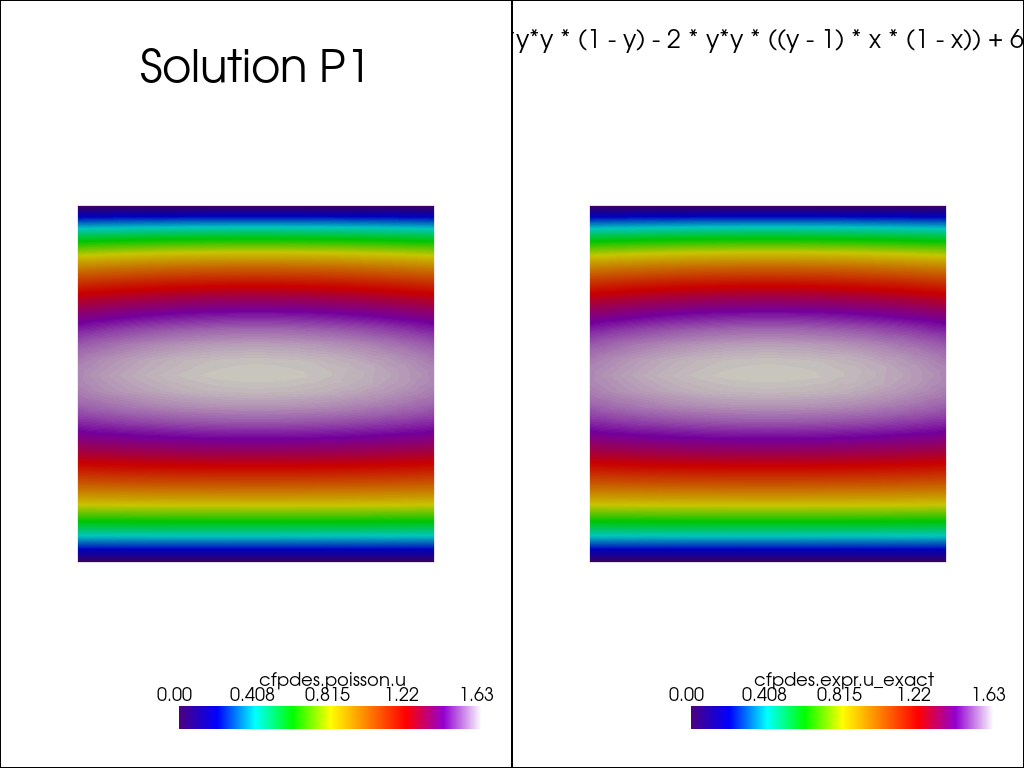

Solving the laplacian problem for hsize = 0.05...
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp-1/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp-1/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                                  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| +----------------------------------------------------------------------------------------+                                                                              |
| | Environment             

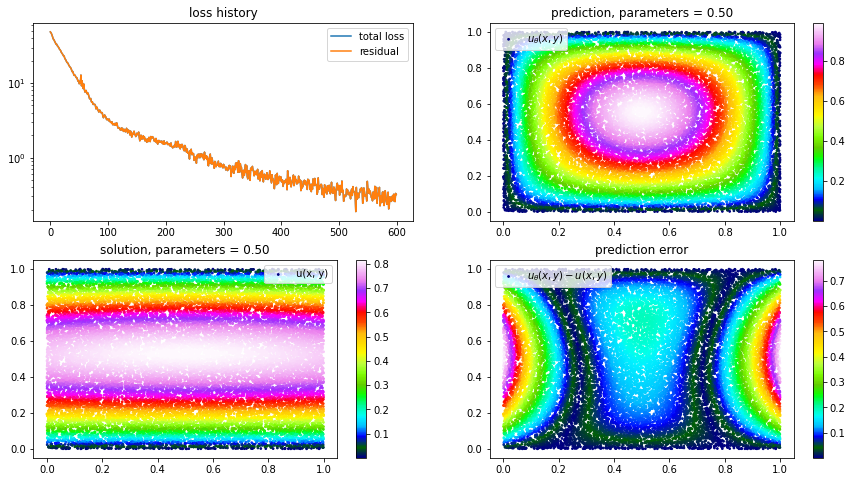

Block 0:
UnstructuredGrid (0x7fd5d069bdc0)
  N Cells:    952
  N Points:   517
  X Bounds:   0.000e+00, 1.000e+00
  Y Bounds:   0.000e+00, 1.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   5
First few coordinates:
[[0.82477343 0.04606718 0.        ]
 [0.8300841  0.10191753 0.        ]
 [0.7806651  0.09123866 0.        ]
 [0.07510737 0.26796353 0.        ]
 [0.10070707 0.30544916 0.        ]]
Number of features in coordinates: 3
Shape of input tensor (coordinates): torch.Size([517, 2])
Shape of mu tensor: torch.Size([517, 1])
Solution array:
[[18.52623825]
 [17.7351736 ]
 [16.99948988]
 [15.81955955]
 [15.50298147]
 [15.82682301]
 [20.94802014]
 [20.9336104 ]
 [19.68366155]
 [17.87376772]
 [18.7716604 ]
 [18.61124214]
 [16.21605301]
 [16.73214194]
 [17.46700021]
 [22.18309647]
 [23.80399603]
 [22.20706718]
 [16.11786652]
 [16.0190424 ]
 [15.64758737]
 [14.82288992]
 [14.94570268]
 [14.75828275]
 [14.63543371]
 [14.91950808]
 [15.1393529 ]
 [14.9233154 ]
 [15.34592448]
 [14.7186

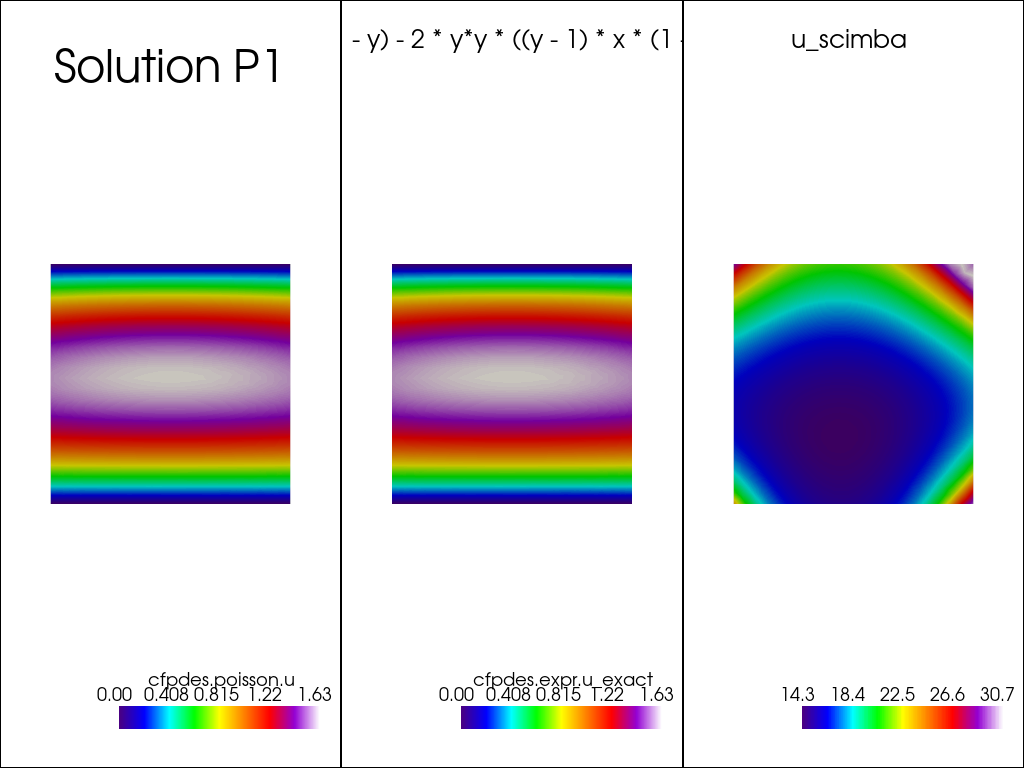

{'Norm_poisson_H1-error': 5.810208051132452, 'Norm_poisson_L2-error': 0.002360064172182224, 'Statistics_mystatA_integrate': 1.0756554582637352, 'Statistics_mystatA_max': 1.629728905752554, 'Statistics_mystatA_mean': 1.0756554582637354, 'Statistics_mystatA_min': 0.011578308161541442}


In [4]:
u_exact = 'y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)'
rhs='-2 * (-6 + x * (2 - 6 * y) + 3 * y - 8 * y*y + 2 * y*y*y + x*x * (-2 + 6 * y))'

P(rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', u_exact = u_exact)
P(rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', solver='scimba', u_exact = u_exact)
print(P.measures)


In [9]:
def runLaplacianPk(P, df, model, fn = f'omega-{P.dim}.geo', verbose=False):
    """Generate the Pk case"""
    meas = dict()
    dim, order, json = model    
    for h in df['h']:
      m = P.measures   #P.feel_solver(filename=fn, h=h, json=json, dim=dim, verbose=verbose)
    for norm in ['L2', 'H1']:
      meas.setdefault(f'P{order}-Norm_poisson_{norm}-error', [])
      meas[f'P{order}-Norm_poisson_{norm}-error'].append(m.pop(f'Norm_poisson_{norm}-error'))

    for key, value in meas.items():
      if len(value) != len(df):
        # Extend the list to match the length of df's index
        value.extend([np.nan] * (len(df) - len(value)))
        meas[key] = value

    df = df.assign(**meas)
    for norm in ['L2', 'H1']:
      df[f'P{order}-poisson_{norm}-convergence-rate']=np.log2(df[f'P{order}-Norm_poisson_{norm}-error'].shift() / df[f'P{order}-Norm_poisson_{norm}-error']) / np.log2(df['h'].shift() / df['h'])

    return df

def runConvergenceAnalysis(P, json,dim=2,hs=[0.1,0.05,0.025, 0.0125],orders=[1,2],verbose=False):
  df=pd.DataFrame({'h':hs})
  for order in orders:
    df=runLaplacianPk(P, df=df,model=[dim,order,json(dim=dim,order=order)],verbose=verbose)
  print('df = ', df.to_markdown())
  return df

def plot_convergence(P, df,dim,orders=[1,2]):
  fig=px.line(df, x="h", y=[f'P{order}-Norm_poisson_{norm}-error' for order,norm in list(itertools.product(orders,['L2','H1']))])
  fig.update_xaxes(title_text="h",type="log")
  fig.update_yaxes(title_text="Error",type="log")
  for order,norm in list(itertools.product(orders,['L2','H1'])):
    fig.update_traces(name=f'P{order} - {norm} error - {df[f"P{order}-poisson_{norm}-convergence-rate"].iloc[-1]:.2f}', selector=dict(name=f'P{order}-Norm_poisson_{norm}-error'))
  fig.update_layout(
          title=f"Convergence rate for the {dim}D Laplacian problem",
          autosize=False,
          width=900,
          height=900,
      )
  return fig


Solving the laplacian problem for hsize = 0.05...
[loadMesh] Loading mesh in format geo+msh: "/workspaces/2024-m1-scimba-feelpp-1/feelppdb/feelpp_cfpde/np_1/omega-2.geo"
[loadMesh] Use default geo desc: /workspaces/2024-m1-scimba-feelpp-1/feelppdb/feelpp_cfpde/np_1/omega-2.geo 0.05 
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| Toolbox::cfpdes-2d-p1 - Use Case Study                                                                                                                 |
+--------------------------------------------------------------------------------------------------------------------------------------------------------+
| +----------------------------------------------------------------------------------------+                                                             |
| | Environment                                                                            |    

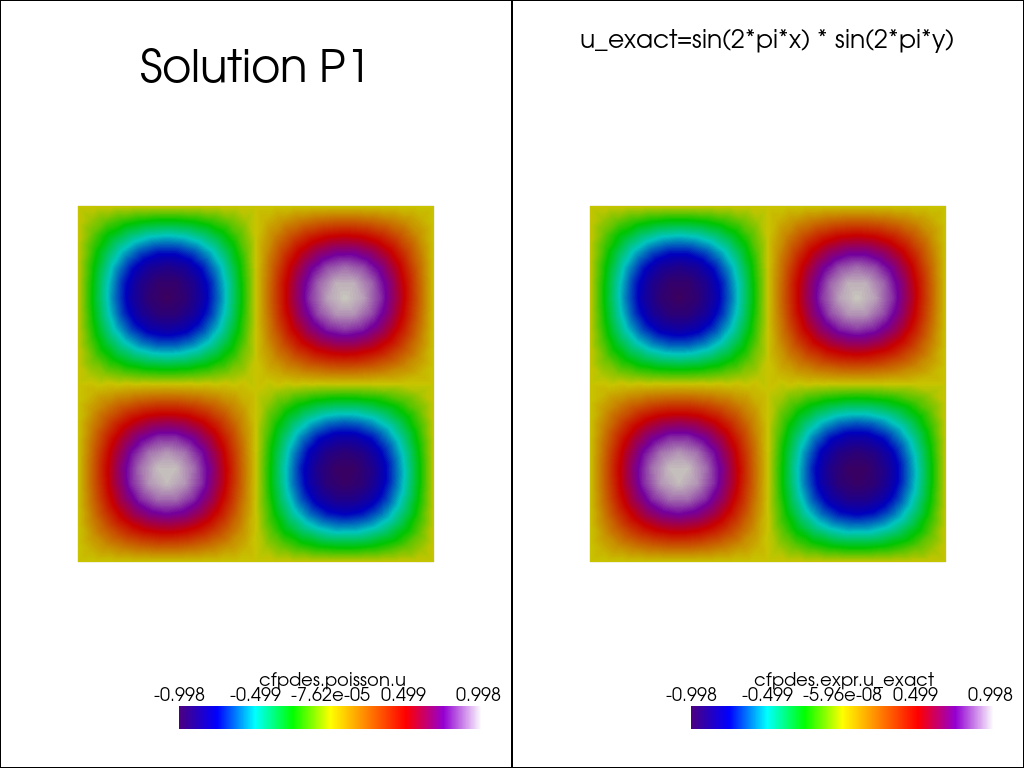

[2, 1, {'Name': 'Poisson', 'ShortName': 'Poisson', 'Models': {'cfpdes-2d-p1': {'equations': 'poisson'}, 'poisson': {'setup': {'unknown': {'basis': 'Pch1', 'name': 'u', 'symbol': 'u'}, 'coefficients': {'c': '{1,0,0,1}:x:y', 'f': '8*pi*pi*sin(2*pi*x) * sin(2*pi*y):x:y'}}}}, 'Materials': {'Omega': {'markers': ['Omega']}}, 'BoundaryConditions': {'poisson': {'Dirichlet': {'g': {'markers': ['Gamma_D'], 'expr': '0:x:y'}}}}, 'PostProcess': {'cfpdes-2d-p1': {'Exports': {'fields': ['all'], 'expr': {'rhs': '8*pi*pi*sin(2*pi*x) * sin(2*pi*y):x:y', 'u_exact': 'sin(2*pi*x) * sin(2*pi*y):x:y', 'grad_u_exact': '{2*pi*cos(2*pi*x)*sin(2*pi*y),2*pi*sin(2*pi*x)*cos(2*pi*y)}:x:y'}}, 'Measures': {'Norm': {'poisson': {'type': ['L2-error', 'H1-error'], 'field': 'poisson.u', 'solution': 'sin(2*pi*x) * sin(2*pi*y):x:y', 'grad_solution': '{2*pi*cos(2*pi*x)*sin(2*pi*y),2*pi*sin(2*pi*x)*cos(2*pi*y)}:x:y', 'markers': 'Omega', 'quad': 6}}, 'Statistics': {'mystatA': {'type': ['min', 'max', 'mean', 'integrate'], 'fiel

KeyError: 'P1-Norm_poisson_L2-error'

In [10]:

u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
rhs = '8*pi*pi*sin(2*pi*x) * sin(2*pi*y)'

P(rhs=rhs, g='0', order=1, u_exact = u_exact)

poisson_json = lambda order,dim=2,name="u": P.model

model=[P.dim,P.order,poisson_json(dim=P.dim,order=P.order)]
print(model)
hs=[0.1,0.05,0.025,0.0125]
df=pd.DataFrame({'h':hs})


df= runLaplacianPk(P, df=df, model=model, verbose=True)
df= runConvergenceAnalysis( P, json=poisson_json,dim=2,verbose=True)


In [ ]:
fig= plot_convergence(P, df,dim=2)
fig.show()

In [ ]:

# for square domain
u_exact = 'sin(2*pi*x) * sin(2*pi*y)'
rhs = '8*pi*pi*sin(2*pi*x) * sin(2*pi*y)'

P(rhs=rhs, g='0', order=1, solver='feelpp', u_exact = u_exact)
P(rhs=rhs, g='0', order=1, solver ='scimba', u_exact = u_exact)

In [ ]:

u_exact = 'y + (x*(1-x) + y*(1-y)/4) '
P(rhs='5/2', g='y',solver='feelpp', u_exact = u_exact)
P(rhs='5/2', g='y', solver ='scimba', u_exact = u_exact)

u_exact = '-y*y/2 - x*y*y*y/2 + y*y*y*y/4'

P( rhs='-1.0-3*y*x+y*y', g='-y*y/2 - x*y*y*y/2 + y*y*y*y/4', order=1, solver='feelpp')
P( rhs='-1.0-3*y*x+y*y', g='-y*y/2 - x*y*y*y/2 + y*y*y*y/4', order=1, solver ='scimba')

In [ ]:


# # 2D with varying anisotropy
P = Poisson(dim = 2)
u_exact = 'x*x/(1+x) + y*y/(1+y)'
P(rhs='4', diff='{1+x,0,0,1+y}', g='x*x/(1+x) + y*y/(1+y)', solver='feelpp', u_exact = u_exact)
P(rhs='4', diff='{1+x,0,0,1+y}', g='x*x/(1+x) + y*y/(1+y)', solver='scimba', u_exact = u_exact)

P(rhs='4', diff='{x,y,-y,x+y}', g='x*x/(1+x) + y*y/(1+y)',  solver='feelp')
P(rhs='4', diff='{1+x,0,0,1+y}', g='x*x/(1+x) + y*y/(1+y)',  solver='scimba')



In [ ]:
from pathlib import Path

import scimba.nets.training_tools as training_tools
import scimba.pinns.pinn_losses as pinn_losses
import scimba.pinns.pinn_x as pinn_x
import scimba.pinns.training_x as training_x
import scimba.sampling.sampling_parameters as sampling_parameters
import scimba.sampling.sampling_pde as sampling_pde
import scimba.sampling.uniform_sampling as uniform_sampling
import torch
from scimba.equations import domain, pdes


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch loaded; device is {device}")

torch.set_default_dtype(torch.double)
torch.set_default_device(device)

PI = 3.14159265358979323846
ELLIPSOID_A = 4 / 3
ELLIPSOID_B = 1 / ELLIPSOID_A


class PoissonDisk2D(pdes.AbstractPDEx):
    def __init__(self, space_domain, 
                 rhs='4*pi*sin(pi*(x*x + y*y)) - 4*pi*pi*(x*x + y*y)*cos(pi*(x*x + y*y))', 
                 diff='(1,0,0,1)', 
                 g='0',
                 u_exact = 'sin(pi*(x*x + y*y))'):
        super().__init__(
            nb_unknowns=1,
            space_domain=space_domain,
            nb_parameters=1,
            parameter_domain=[[0.5, 1]],
        )

        self.rhs = rhs
        self.diff = diff
        self.g = g
        self.u_exact = u_exact 
        self.first_derivative = True
        self.second_derivative = True

    def bc_residual(self, w, x, mu, **kwargs):
        u = self.get_variables(w)
        x1, x2 = x.get_coordinates()
        g_evaluated = eval(self.g, {'x': x1, 'y': x2, 'pi': PI, 'sin' : torch.sin, 'cos': torch.cos})
        return u - g_evaluated

    def residual(self, w, x, mu, **kwargs):
        x1, x2 = x.get_coordinates()
        alpha = self.get_parameters(mu)
        u_xx = self.get_variables(w, "w_xx")
        u_yy = self.get_variables(w, "w_yy")

        f = eval(self.rhs, {'x': x1, 'y': x2, 'pi': PI, 'sin': torch.sin, 'cos': torch.cos})
        diff = eval(self.diff, {'x': x1, 'y': x2, 'pi': PI, 'sin' : torch.sin, 'cos': torch.cos})
        
        return alpha*(u_xx * diff[0] + u_yy * diff[3] + f )


    def reference_solution(self, x, mu):
        x1, x2 = x.get_coordinates()
        alpha = self.get_parameters(mu)

        return alpha *eval(self.u_exact, {'x': x1, 'y': x2, 'pi': PI, 'sin': torch.sin, 'cos': torch.cos})


class Poisson_2D(pdes.AbstractPDEx):
    def __init__(self, space_domain,  
                 rhs='8*pi*pi*sin(2*pi*x)*sin(2*pi*y)', 
                 diff='(1,0,0,1)', 
                 g='0',
                 u_exact='sin(2 * pi * x) * sin(2 * pi * y)'):
        super().__init__(
            nb_unknowns=1,
            space_domain=space_domain,
            nb_parameters=1,
            parameter_domain=[[0.50000, 0.500001]],           
        )
        self.rhs = rhs
        self.diff = diff
        self.g = g
        self.u_exact = u_exact
        self.first_derivative = True
        self.second_derivative = True

    def bc_residual(self, w, x, mu, **kwargs):
        u = self.get_variables(w)
        # Évaluation de la condition aux limites g
        x1, x2 = x.get_coordinates()
        g_evaluated = eval(self.g, {'x': x1, 'y': x2, 'pi': PI, 'sin' : torch.sin, 'cos': torch.cos})
        return u - g_evaluated

    def residual(self, w, x, mu, **kwargs):
        x1, x2 = x.get_coordinates()
        alpha = self.get_parameters(mu)
        u_xx = self.get_variables(w, "w_xx")
        u_yy = self.get_variables(w, "w_yy")

        f = eval(self.rhs, {'x': x1, 'y': x2, 'pi': PI, 'sin' : torch.sin, 'cos': torch.cos})
        diff = eval(self.diff, {'x': x1, 'y': x2, 'pi': PI, 'sin' : torch.sin, 'cos': torch.cos})
    
        return alpha *(u_xx * diff[0] + u_yy * diff[3] + f)  

    def post_processing(self, x, mu, w):
        x1, x2 = x.get_coordinates()
        return x1 * (1 - x1) * x2 * (1 - x2) * w

    def reference_solution(self, x, mu):
        x1, x2 = x.get_coordinates()
        alpha = self.get_parameters(mu)
        return alpha * eval(self.u_exact, {'x': x1, 'y': x2, 'pi': PI, 'sin': torch.sin, 'cos': torch.cos})

class Poisson_2D_ellipse(pdes.AbstractPDEx):
    def __init__(self, space_domain):
        super().__init__(
            nb_unknowns=1,
            space_domain=space_domain,
            nb_parameters=0,
            parameter_domain=[[0.99999, 1]],
        )

        self.first_derivative = True
        self.second_derivative = True

    def make_data(self, n_data):
        pass

    def bc_residual(self, w, x, mu, **kwargs):
        u = self.get_variables(w)
        return u

    def residual(self, w, x, mu, **kwargs):
        x1, x2 = x.get_coordinates()
        u_xx = self.get_variables(w, "w_xx")
        u_yy = self.get_variables(w, "w_yy")
        f = 1
        return u_xx + u_yy + f

    def reference_solution(self, x, mu):
        x1, x2 = x.get_coordinates()
        x1_0, x2_0 = self.space_domain.large_domain.center
        a, b = ELLIPSOID_A, ELLIPSOID_B
        rho = 0.5 / (1 / a**2 + 1 / b**2)
        return rho * (1 - ((x1 - x1_0) / a) ** 2 - ((x2 - x2_0) / b) ** 2)


def disk_to_ellipse(x):
    x1, x2 = (x[:, i, None] for i in range(2))
    return torch.cat((x1 * ELLIPSOID_A, x2 * ELLIPSOID_B), axis=1)


def Jacobian_disk_to_ellipse(x):
    x1, x2 = (x[:, i, None] for i in range(2))
    return ELLIPSOID_A, 0, 0, ELLIPSOID_B


def disk_to_potato(x):
    x1, x2 = (x[:, i, None] for i in range(2))
    x = x1 - 0.5 * x2**2 + 0.3 * torch.sin(x2)
    y = x2 + 0.1 * x + 0.12 * torch.cos(x)
    return torch.cat((x, y), axis=1)


def Jacobian_disk_to_potato(x):
    x1, x2 = (x[:, i, None] for i in range(2))
    raise ValueError("Jacobian_disk_to_potato is not implemented")
    return 0, 0, 0, 0


def Run_laplacian2D(pde, bc_loss_bool=False, w_bc=0, w_res=1.0):
    x_sampler = sampling_pde.XSampler(pde=pde)
    mu_sampler = sampling_parameters.MuSampler(
        sampler=uniform_sampling.UniformSampling, model=pde
    )
    sampler = sampling_pde.PdeXCartesianSampler(x_sampler, mu_sampler)

    file_name = "test.pth"
    #new_training = False
    new_training = True

    if new_training:
        (
            Path.cwd()
            / Path(training_x.TrainerPINNSpace.FOLDER_FOR_SAVED_NETWORKS)
            / file_name
        ).unlink(missing_ok=True)

    tlayers = [20, 20, 20, 20, 20]
    network = pinn_x.MLP_x(pde=pde, layer_sizes=tlayers, activation_type="sine")
    pinn = pinn_x.PINNx(network, pde)
    losses = pinn_losses.PinnLossesData(
        bc_loss_bool=bc_loss_bool, w_res=w_res, w_bc=w_bc
    )
    optimizers = training_tools.OptimizerData(learning_rate=1.2e-2, decay=0.99)
    trainer = training_x.TrainerPINNSpace(
        pde=pde,
        network=pinn,
        sampler=sampler,
        losses=losses,
        optimizers=optimizers,
        file_name=file_name,
        batch_size=5000,
    )

    if not bc_loss_bool:
        if new_training:
            trainer.train(epochs=600, n_collocation=5000, n_data=0)
    else:
        if new_training:
            trainer.train(
                epochs=600, n_collocation=5000, n_bc_collocation=1000, n_data=0
            )

    trainer.plot(20000, reference_solution=True)
    #trainer.plot_derivative_mu(n_visu=20000)
    return network, pde


if __name__ == "__main__":
    # Laplacien strong Bc on Square with nn
    xdomain = domain.SpaceDomain(2, domain.SquareDomain(2, [[0.0, 1.0], [0.0, 1.0]]))
    print(xdomain)

    u_exact='sin(2 * pi * x) * sin(2 * pi * y)'       
    pde = Poisson_2D(xdomain,  rhs='8*pi*pi*sin(2*pi*x)*sin(2*pi*y)', g='0',  u_exact=u_exact)
    network, pde = Run_laplacian2D(pde)

    u_exact = 'x*x*(1+x) + y*y*(1+y)'
    pde = Poisson_2D(xdomain, rhs='2*(1-2*x)*y**2*(1-y) + 2*(1-2*y)*x**2*(1-x)', diff='(1+x,0,0,1+y)', g='0', u_exact=u_exact)
    network, pde = Run_laplacian2D(pde)
    
    u_exact = 'y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)'
    rhs='-2 * (-6 + x * (2 - 6 * y) + 3 * y - 8 * y*y + 2 * y*y*y + x*x * (-2 + 6 * y))'

    pde = Poisson_2D(xdomain, rhs=rhs, g='y*y*y * (1 - y) - 2 * y*y * ((y - 1) * x * (1 - x)) + 6 * y * (1 - y)', u_exact = u_exact)
    network, pde = Run_laplacian2D(pde)

    xdomain = domain.SpaceDomain(2, domain.DiskBasedDomain(2, center=[0.0, 0.0], radius=1.0))
    u_exact =  'sin(pi*(x*x + y*y))'
    rhs = '4*pi*sin(pi*(x*x + y*y)) - 4*pi*pi*(x*x + y*y)*cos(pi*(x*x + y*y))'

    pde_disk = PoissonDisk2D(xdomain,  rhs= rhs, g= '0', u_exact=u_exact)
    network, pde = Run_laplacian2D(pde_disk)
    
    


    # Extract solution function u
    u = network.forward
    # Generate example input data and get the solution from the network
    input_tensor = torch.randn(100, 2)  # Generate some example input data
    mu = torch.tensor([[0.5]]).repeat(input_tensor.size(0), 1)  # Expand and repeat mu to match the batch size
    solution_tensor = u(input_tensor, mu)   # Get the solution from the network

    # Convert the tensor to a NumPy array
    solution_array = solution_tensor.detach().numpy()
    print('solution = ', solution_array)


In [ ]:
from pathlib import Path

import scimba.nets.training_tools as training_tools
import scimba.pinns.pinn_losses as pinn_losses
import scimba.pinns.pinn_x as pinn_x
import scimba.pinns.training_x as training_x
import scimba.sampling.sampling_parameters as sampling_parameters
import scimba.sampling.sampling_pde as sampling_pde
import scimba.sampling.uniform_sampling as uniform_sampling
import torch
from scimba.equations import domain, pdes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch loaded; device is {device}")

torch.set_default_dtype(torch.double)
torch.set_default_device(device)

PI = 3.14159265358979323846
ELLIPSOID_A = 4 / 3
ELLIPSOID_B = 1 / ELLIPSOID_A


class PoissonDisk2D(pdes.AbstractPDEx):
    def __init__(self, space_domain):
        super().__init__(
            nb_unknowns=1,
            space_domain=space_domain,
            nb_parameters=1,
            parameter_domain=[[0.5, 1]],
        )

        self.first_derivative = True
        self.second_derivative = True

    def make_data(self, n_data):
        pass

    def bc_residual(self, w, x, mu, **kwargs):
        return self.get_variables(w)

    def residual(self, w, x, mu, **kwargs):
        x1, x2 = x.get_coordinates()
        u_xx = self.get_variables(w, "w_xx")
        u_yy = self.get_variables(w, "w_yy")
        f = self.get_parameters(mu)
        return u_xx + u_yy + f

    def reference_solution(self, x, mu):
        x1, x2 = x.get_coordinates()
        x1_0, x2_0 = self.space_domain.large_domain.center
        f = self.get_parameters(mu)
        return 0.25 * f * (1 - (x1 - x1_0) ** 2 - (x2 - x2_0) ** 2)


class Poisson_2D(pdes.AbstractPDEx):
    def __init__(self, space_domain):
        super().__init__(
            nb_unknowns=1,
            space_domain=space_domain,
            nb_parameters=1,
            parameter_domain=[[0.50000, 0.500001]],
        )

        self.first_derivative = True
        self.second_derivative = True

    def make_data(self, n_data):
        pass

    def bc_residual(self, w, x, mu, **kwargs):
        u = self.get_variables(w)
        return u

    def residual(self, w, x, mu, **kwargs):
        x1, x2 = x.get_coordinates()
        alpha = self.get_parameters(mu)
        u_xx = self.get_variables(w, "w_xx")
        u_yy = self.get_variables(w, "w_yy")
        f = 8 * PI**2 * alpha * torch.sin(2 * PI * x1) * torch.sin(2 * PI * x2)
        return u_xx + u_yy + f

    def post_processing(self, x, mu, w):
        x1, x2 = x.get_coordinates()
        return x1 * (1 - x1) * x2 * (1 - x2) * w

    def reference_solution(self, x, mu):
        x1, x2 = x.get_coordinates()
        alpha = self.get_parameters(mu)
        return alpha * torch.sin(2 * PI * x1) * torch.sin(2 * PI * x2)


class Poisson_2D_ellipse(pdes.AbstractPDEx):
    def __init__(self, space_domain):
        super().__init__(
            nb_unknowns=1,
            space_domain=space_domain,
            nb_parameters=0,
            parameter_domain=[[0.99999, 1]],
        )

        self.first_derivative = True
        self.second_derivative = True

    def make_data(self, n_data):
        pass

    def bc_residual(self, w, x, mu, **kwargs):
        u = self.get_variables(w)
        return u

    def residual(self, w, x, mu, **kwargs):
        x1, x2 = x.get_coordinates()
        u_xx = self.get_variables(w, "w_xx")
        u_yy = self.get_variables(w, "w_yy")
        f = 1
        return u_xx + u_yy + f

    def reference_solution(self, x, mu):
        x1, x2 = x.get_coordinates()
        x1_0, x2_0 = self.space_domain.large_domain.center
        a, b = ELLIPSOID_A, ELLIPSOID_B
        rho = 0.5 / (1 / a**2 + 1 / b**2)
        return rho * (1 - ((x1 - x1_0) / a) ** 2 - ((x2 - x2_0) / b) ** 2)


def disk_to_ellipse(x):
    x1, x2 = (x[:, i, None] for i in range(2))
    return torch.cat((x1 * ELLIPSOID_A, x2 * ELLIPSOID_B), axis=1)


def Jacobian_disk_to_ellipse(x):
    x1, x2 = (x[:, i, None] for i in range(2))
    return ELLIPSOID_A, 0, 0, ELLIPSOID_B


def disk_to_potato(x):
    x1, x2 = (x[:, i, None] for i in range(2))
    x = x1 - 0.5 * x2**2 + 0.3 * torch.sin(x2)
    y = x2 + 0.1 * x + 0.12 * torch.cos(x)
    return torch.cat((x, y), axis=1)


def Jacobian_disk_to_potato(x):
    x1, x2 = (x[:, i, None] for i in range(2))
    raise ValueError("Jacobian_disk_to_potato is not implemented")
    return 0, 0, 0, 0


def Run_laplacian2D(pde, bc_loss_bool=False, w_bc=0, w_res=1.0):
    x_sampler = sampling_pde.XSampler(pde=pde)
    mu_sampler = sampling_parameters.MuSampler(
        sampler=uniform_sampling.UniformSampling, model=pde
    )
    sampler = sampling_pde.PdeXCartesianSampler(x_sampler, mu_sampler)

    file_name = "test.pth"
    # new_training = False
    new_training = True

    if new_training:
        (
            Path.cwd()
            / Path(training_x.TrainerPINNSpace.FOLDER_FOR_SAVED_NETWORKS)
            / file_name
        ).unlink(missing_ok=True)

    tlayers = [20, 20, 20, 20, 20]
    network = pinn_x.MLP_x(pde=pde, layer_sizes=tlayers, activation_type="sine")
    pinn = pinn_x.PINNx(network, pde)
    losses = pinn_losses.PinnLossesData(
        bc_loss_bool=bc_loss_bool, w_res=w_res, w_bc=w_bc
    )
    optimizers = training_tools.OptimizerData(learning_rate=1.2e-2, decay=0.99)
    trainer = training_x.TrainerPINNSpace(
        pde=pde,
        network=pinn,
        sampler=sampler,
        losses=losses,
        optimizers=optimizers,
        file_name=file_name,
        batch_size=5000,
    )

    if not bc_loss_bool:
        if new_training:
            trainer.train(epochs=600, n_collocation=5000, n_data=0)
    else:
        if new_training:
            trainer.train(
                epochs=600, n_collocation=5000, n_bc_collocation=1000, n_data=0
            )

    trainer.plot(20000, reference_solution=True)
    # trainer.plot_derivative_mu(n_visu=20000)


if __name__ == "__main__":
    # Laplacien strong Bc on Square with nn
    xdomain = domain.SpaceDomain(2, domain.SquareDomain(2, [[0.0, 1.0], [0.0, 1.0]]))
    print(xdomain)
    pde = Poisson_2D(xdomain)

    Run_laplacian2D(pde)

    # Laplacian on circle with nn
    xdomain = domain.SpaceDomain(2, domain.DiskBasedDomain(2, [0.5, 0.5], 1.0))
    pde = PoissonDisk2D(xdomain)

    Run_laplacian2D(pde, bc_loss_bool=True, w_bc=10, w_res=0.1)

    # Laplacian on ellipse and mapping with nn
    xdomain = domain.SpaceDomain(
        2,
        domain.DiskBasedDomain(
            2,
            [0.0, 0.0],
            1.0,
            mapping=disk_to_ellipse,
            Jacobian=Jacobian_disk_to_ellipse,
        ),
    )
    pde = Poisson_2D_ellipse(xdomain)
    Run_laplacian2D(pde, bc_loss_bool=True, w_bc=10, w_res=0.1)

    # Laplacian on potato and mapping with nn
    xdomain = domain.SpaceDomain(
        2,
        domain.DiskBasedDomain(
            2, [0.0, 0.0], 1.0, mapping=disk_to_potato, Jacobian=Jacobian_disk_to_potato
        ),
    )
    pde = Poisson_2D_ellipse(xdomain)
    Run_laplacian2D(pde, bc_loss_bool=True, w_bc=10, w_res=0.1)


In [ ]:
import pyvista as pv

# File path to the .case file
file_path = 'cfpdes-2d-p1.exports/Export.case'

# Read the .case file using PyVista
data = pv.read(file_path)

# Iterate over each block in the dataset
for i, block in enumerate(data):
    if block is None:
        continue


    print(f"Block {i}:")
    print(block)
    k = 0
    # Extract the mesh points (coordinates)
    coordinates = block.points
    

print('k = ', k)


In [ ]:
import pyvista as pv
import torch

u_scimba = P.scimba_solver(verbose=True)

# File path to the .case file
file_path = 'cfpdes-2d-p1.exports/Export.case'

# Read the .case file using PyVista
data = pv.read(file_path)

# Iterate over each block in the dataset to find coordinates
coordinates = None
for i, block in enumerate(data):
    if block is None:
        continue

    print(f"Block {i}:")
    print(block)
    
    # Extract the mesh points (coordinates)
    coordinates = block.points

# Ensure coordinates are found
if coordinates is None:
    raise ValueError("No coordinates found in the mesh blocks.")

# Print the first few coordinates to understand their structure
print("First few coordinates:")
print(coordinates[:5])

# Determine the number of features
num_features = coordinates.shape[1]
print(f"Number of features in coordinates: {num_features}")

# If there are more features than expected, strip the extra ones
if num_features > 2:
    coordinates = coordinates[:, :2]  # Keep only the first two features (x, y)

# Convert coordinates to a PyTorch tensor
input_tensor = torch.tensor(coordinates, dtype=torch.double)
print(f"Shape of input tensor (coordinates): {input_tensor.shape}")

# Create the mu tensor with correct shape
mu_value = 0.5  # Example value for mu
mu = torch.full((input_tensor.size(0), 1), mu_value, dtype=torch.double)
print(f"Shape of mu tensor: {mu.shape}")

# Pass input tensor and mu tensor separately to the network
solution_tensor = u_scimba(input_tensor, mu)

# Convert the tensor to a NumPy array
solution_array = solution_tensor.detach().numpy()

# Print solution array
print("Solution array:")
print(solution_array)
